# Increasing Gain-bandwidth product of JPA 

written by Reet Mhaske; 
Mentored and guided by Nicolas Zapata and Prof. Ioan Pop

The code hear makes use of the theory developed in the Msc thesis of Patrick Winkel, specifically from Appendix F. The equations referenced here refer to the same thesis.



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
from matplotlib.pyplot import figure
import mpmath as mp
import matplotlib as mpl
from qutip import *
import scipy

In [4]:
from scipy.optimize import curve_fit

In [5]:
import circuit_test

In [11]:
j=complex(0,1) # squareroot of unity
e=1.6*10**-19  # electronic charge
hbar=1.0545*(10**-34)  #reduced planck's constant
phi_quantum=hbar*2*np.pi/(2*e) # flux quantum

In [12]:
 # standard values in Patrcik's thesis, Appendix F.3
C_j= 1*(10**-12) 
C_o= 1/2500*(10**-12) 
L_j= 50*(10**-12)
omega_pl= 1/np.sqrt(L_j*(C_j + C_o/4))
Z_o=50

E_j =  hbar*phi_quantum/(2*e*2*np.pi * L_j) 


# Eigenmodes of a josephson array

In [7]:
# function to return eigenvalues and eigenmodes of a an array

def freq_modes(n, C_j= 1*(10**-12) , C_o= 1/2500*(10**-12) , L_j= 50*(10**-12) , actual_eigstates=False):
    C = np.zeros(shape=(n,n))
    L_inv = np.zeros(shape=(n,n))
    
    # initializing the capacitance and inductance matrices.
    # the following initialises them for galvanic coupling. Appropriately change for capacitive coupling
    #eq 169 and eq 170
    
    C[0,0]=C_o+2*C_j
    C[n-1,n-1]=C_o+2*C_j
    L_inv[0,0]=2/L_j
    L_inv[n-1,n-1]=2/L_j

    for i in range(0,n):
        C[i,i]=C_o+2*C_j
        if (i!=0): C[i,i-1]=-C_j
        if (i!=n-1): C[i,i+1]=-C_j
    for i in range(1,n-1):
        L_inv[i,i]=2/L_j
        if (i!=0):  L_inv[i,i-1]=-1/L_j
        if (i!=n-1):  L_inv[i,i+1]=-1/L_j 
                
    C_qutip=Qobj(C)
    L_inv_qutip=Qobj(L_inv)  
    # using qutip to find invers, squareroot and eigenvalues,eigenfunctions
    Omega = C_qutip.sqrtm().inv() * L_inv_qutip * C_qutip.sqrtm().inv()
    eigvals,eigstates= Omega.eigenstates()
    
    # return either the actual eigenfucntions for scaled ones
    # eq 174 and eq 175
    # eigenvals are omega_m^2, so take sqrt of them to get omega_m
    # actual eigenstates correspond to eq 175
    
    #in the following, sqrt(hbar) is not used and must be multiplied later whenever using the eigfunctions and eigvals
    
    if (actual_eigstates==True):
        for i in range(0,len(eigstates)):
            eigstates[i] = ((eigvals[i]**-0.25)/2**0.5)*C_qutip.sqrtm().inv() *eigstates[i] # ignoring sqrt(h_bar)
    return eigvals, eigstates     

C:\Users\REET\miniconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Frequencies modes for different N')

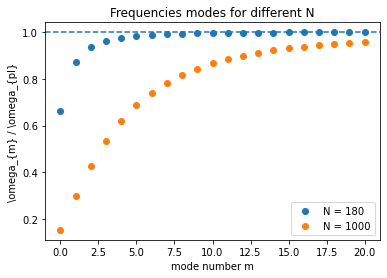

In [8]:
# plot eig values for diff modes
# Fig 26.b from thesis
m_axis= range(0,21)    
for N in [180,1000]:
    eigvals_,eigstates_=freq_modes(N)
    plt.scatter(m_axis,np.sqrt(eigvals_[:21])/omega_pl,label=f"N = {N}")
    plt.legend()
plt.axhline(1,linestyle='dashed')
plt.ylabel(r"\omega_{m} / \omega_{pl}")
plt.xlabel("mode number m")
plt.title("Frequencies modes for different N") 

Text(0.5, 1.0, 'Galvanic coupling Frequencies modes for N =100')

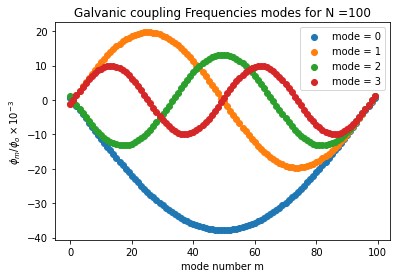

In [44]:
# plot eigenfucntions
N=100
nodes_axis=range(0,N)
omega_pl= 1/np.sqrt(L_j*(L_j + C_o/4))
eigvals_N,eigfunctns_N= freq_modes(N,actual_eigstates=True)
for i in range(0,4):
    plt.scatter(nodes_axis,eigfunctns_N[i]/phi_quantum * np.sqrt(hbar) *10**3 ,label=f"mode = {i}")
plt.legend()
plt.ylabel(r"$\phi_{m}/\phi_{o} \times 10^{-3} $ ")
plt.xlabel("mode number m")
plt.title(f"Galvanic coupling Frequencies modes for N ={N}") 

# Finding Kerr coefficients of different modes

To find $K_m,k$ we use eq 184 and 185, which have the term $\eta_{mm,kk}$. We define them below

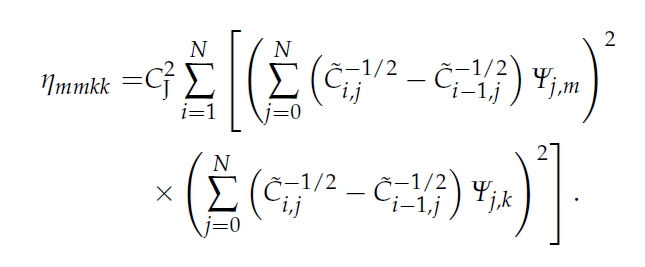

In [26]:
# define eta using eq 186

def eta(m,k, n,eigvals,eigenstates,C_j,C_o):   
    
    # define the capacitance matrix 
    
    C = np.zeros(shape=(n,n))
    C[0,0]=C_o+2*C_j
    C[n-1,n-1]=C_o+2*C_j
    for i in range(0,n):
        C[i,i]=C_o+2*C_j
        if (i!=0): C[i,i-1]=-C_j
        if (i!=n-1): C[i,i+1]=-C_j
    C_qutip=Qobj(C)
    C_inv_sqrtm = np.array( C_qutip.sqrtm().inv())
    
    
    # perform the summation
    sum_net=0
    for i in range(1,n):
        sum1 =0
        sum2 =0
        for l in range(0,n):
            sum1+= ( (C_inv_sqrtm[i,l] - C_inv_sqrtm[i-1,l]) * np.array(eigenstates)[m][l])
        for l in range(0,n):
            sum2+= ( (C_inv_sqrtm[i,l] - C_inv_sqrtm[i-1,l]) * np.array(eigenstates)[k][l])
        sum_net +=(sum1**2)*(sum2**2)    
        
    return sum_net * (C_j**2)
   

 

Find actual $K_{m,n}$ using 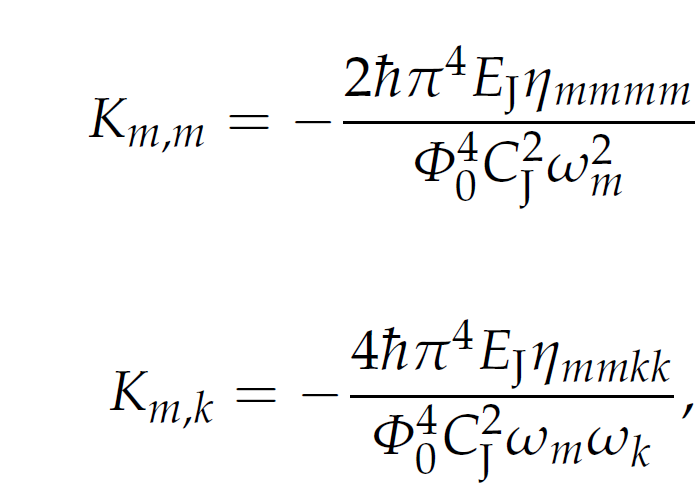

In [231]:
# an array of size 100
N=100
mode_axis=range(0,21)

# Kerr_axis[m,n] will store K_{n,n+m} 
# Kerr axis is 2d array, with first index of which order of Kerr coefficiet 
# Each first index corresponds to 1D array to store kerr coeff for different modes
# we only plot K_{m,m} and K_{m,m+1}
Kerr_axis = np.zeros(shape=(2,len(mode_axis)),dtype=np.complex_)
eta_temp_axis = np.zeros(shape=(2,len(mode_axis)),dtype=np.complex_)
eigvals_,eigstates_ = freq_modes(N,C_o=C_o,actual_eigstates=False)

for k in range(0,2):
    for l in range(0,len(mode_axis)):
        m=mode_axis[l]
        eta_temp_axis[k,l]=eta(m,m+k,N,eigvals_,eigstates_,C_j,C_o)/np.sqrt(((eigvals_[l])*((eigvals_[l+k])))) 
 # as eta differs from K by  factors of omega_m and omega_k,
#the above eta_temp_axis holds the Kerr coefficients upto some constant factors   
    
    Kerr_axis[k] = eta_temp_axis[k]* 4*hbar*(np.pi**4)*E_j/((phi_quantum**4)*(C_j**2))
    # mulipliy constant factors
#  divide self kerr term by appropriate factor of 0.5 to get the correct term (eq 184 and eq 185)  
Kerr_axis[0] = Kerr_axis[0]/2


Text(0.5, 1.0, 'Kerr coefficients $K_{k,m}$ for different modes for N =100 ')

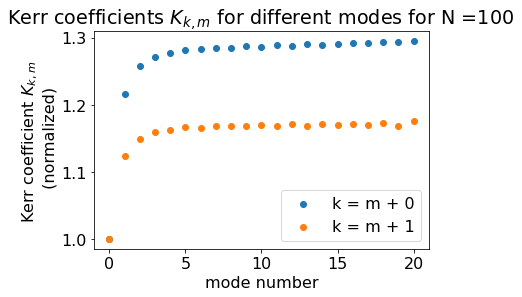

In [237]:
# plot the self and cross kerr as the ratio with the first kerr coefficient

# Note, that there is some error in the actual values here due to multiplicative factors
#, but the ratio is correct
for k in range(0,2):
    plt.scatter(mode_axis,Kerr_axis[k]/Kerr_axis[k][0],label=f"k = m + {k}")
plt.legend()    
plt.xlabel("mode number")
plt.ylabel("Kerr coefficient $K_{k,m}$ \n (normalized)")
plt.title("Kerr coefficients $K_{k,m}$ for different modes for N =100 ")

# Finding Kerr coefficient for different $C_o$ values

In [241]:
# change Z-0 to 10 ohm as it gives a better picture and the graph's nature is clear 
Z_o =10

In [254]:
# C_o range is logarithmic, replace by np.linspace for linear scale
C_o_range=np.logspace(np.log10(1*(10**-12)/2500),np.log10(600*(10**-12)/2500),6)

# calculate upto first 11 modes
mode_axis=range(0,11)

# Kerr_axis here is 3d
# first axis corresponds to which C_o value
# second axis to which order of Kerr coefficient
# 3rd axis stores Kerr coeff for different modes
# Kerr_axis[i,j,m] stores K_{m,m+j} for a value of C_o=C_o_range[i]

Kerr_axis = np.zeros(shape=(len(C_o_range),2,len(mode_axis)),dtype=np.complex_)
# some temporary axis
eta_temp_axis = np.zeros(shape=(2,len(mode_axis)),dtype=np.complex_)
N=100
# interate over all C_o values, rest is the same code as finding Kerr coeff for a fixed C_o

for C_index in range(0,len(C_o_range)):
    
    eigvals_,eigstates_ = freq_modes(N,C_o=C_o_range[C_index],actual_eigstates=False)
    for k in range(0,2):
        for l in range(0,len(mode_axis)):
            m=mode_axis[l]
            eta_temp_axis[k,l]=eta(m,m+k,N,eigvals_,eigstates_,C_j,C_o_range[C_index])/np.sqrt(((eigvals_[l])*((eigvals_[l+k])))) 
        Kerr_axis[C_index,k] = eta_temp_axis[k]* 4*hbar*(np.pi**4)*E_j/((phi_quantum**4)*(C_j**2))
    Kerr_axis[C_index,0] = Kerr_axis[C_index,0]/2
    


C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: Complex

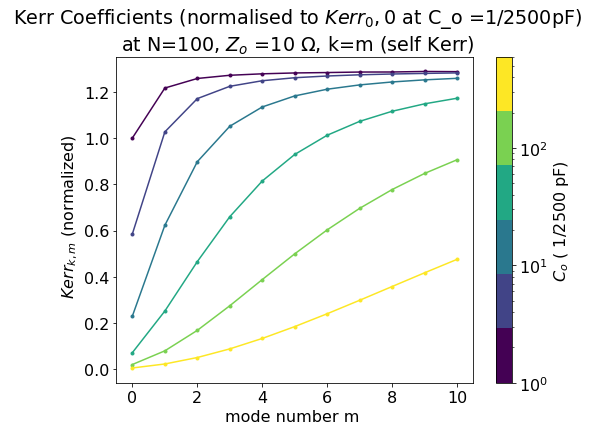

In [255]:
# plot the Kerr coeff for diff modes, with the C_o values on the color bar

cmap = plt.get_cmap('viridis',len(C_o_range))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
for i in range(0,len(C_o_range)):
    ax1.plot(range(0,len(mode_axis)),Kerr_axis[i][0]/Kerr_axis[0][0][0] , \ # remove division for actual value
                color=cmap(i),marker='.')
plt.title(f" Kerr Coefficients (normalised to $Kerr_0,0$ at C_o =1/2500pF)\n at N={N}, $Z_o$ ={Z_o} $\Omega$, k=m (self Kerr)")
plt.xlabel("mode number m ")
plt.ylabel("  $Kerr_{k,m}$ (normalized) ")
# Normalizer

norm = mpl.colors.LogNorm(vmin=min(C_o_range/(1/2500*10**-12)), vmax=max(C_o_range/(1/2500*10**-12)))  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,label="$C_o$ ( 1/2500 pF)")
plt.show()

In [ ]:
# Plot the cross Kerr coefficients

cmap = plt.get_cmap('viridis',len(C_o_range))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
for i in range(0,len(C_o_range)):
    ax1.plot(range(0,len(mode_axis)),Kerr_axis[i][1]//Kerr_axis[0][1][0] ,\# remove division for actual value
                color=cmap(i),marker='.')
plt.title(f"N={N}, $Z_o$ ={Z_o} $\Omega$, k=m+1 (cross Kerr)")
plt.xlabel("mode number m ")
plt.ylabel("  $Kerr_{k,m}$(normalized)")
# Normalizer

norm = mpl.colors.LogNorm(vmin=min(C_o_range/(1/2500*10**-12)), vmax=max(C_o_range/(1/2500*10**-12)))  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,label="$C_o$ ( 1/2500 pF)")
plt.show()

Note: The above two plots are for normalised Kerr. 

# Kerr coefficients for different length of arrays

We see of Kerr coefficients change on changing the length of arrays 

In [84]:
# Warning! This code takes a lot of time for execution,as for large N, the matrices become difficult to manipulate by qiskit.

C_o_range=np.linspace(1*(10**-12)/2500,600*(10**-12)/2500,10)
N_range=range(100,1000,100)
mode_axis=range(2,4)

#Kerr_axis now has a new dim for differnet Array lengths
Kerr_axis = np.zeros(shape=(len(C_o_range),len(N_range),2,len(mode_axis)),dtype=np.complex_)
eta_temp_axis = np.zeros(shape=(2,len(mode_axis)),dtype=np.complex_)
N=100
for C_index in range(0,len(C_o_range)):
    print(C_index)
    for N_index in range(0,len(N_range)):
        eigvals_,eigstates_ = freq_modes(N_range[N_index],C_o=C_o_range[C_index],actual_eigstates=False)
        for k in range(0,2):
            for l in range(0,len(mode_axis)):
                m=mode_axis[l]
                eta_temp_axis[k,l]=eta(m,m+k,N_range[N_index],eigvals_,eigstates_,C_j,C_o_range[C_index])/np.sqrt(((eigvals_[l])*((eigvals_[l+k])))) 
            Kerr_axis[C_index,N_index,k] = eta_temp_axis[k]* 4*hbar*(np.pi**4)*E_j/((phi_quantum**4)*(C_j**2))
        Kerr_axis[C_index,N_index,0] = Kerr_axis[C_index,N_index,0]/2

0


KeyboardInterrupt: 

C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\REET\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: Complex

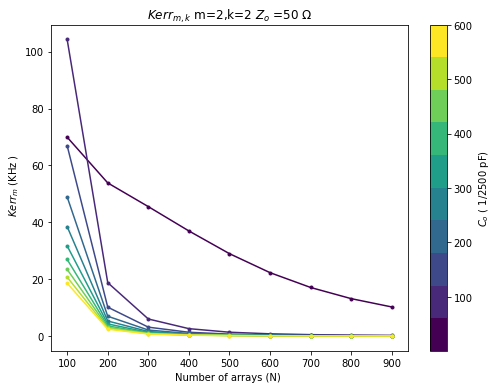

In [43]:
#Plot K for diff N, for a particular mode, with color bar showing C_o, 

cmap = plt.get_cmap('viridis',len(C_o_range))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
for i in range(0,len(C_o_range)):
        ax1.plot(N_range,Kerr_axis[i,:,0,0]/N_range,Kerr_axis[i,0,0,0] , \
                color=cmap(i),marker='.')
plt.title(r"$Kerr_{m,k}$ m=2,k=2 $Z_o$ =50 $\Omega$")
plt.xlabel("Number of arrays (N) ")
plt.ylabel("  $Kerr_{m,k}$ (normalized)")
# Normalizer
norm = mpl.colors.Normalize(vmin=min(C_o_range/(1/2500*10**-12)), vmax=max(C_o_range/(1/2500*10**-12)))  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,label="$C_o$ ( 1/2500 pF)")
plt.show()

### Preliminary version of code for changing N, can move to next section and  skip following three cells

In [14]:
N_axis = range(100,500,50)
C_o_range = np.linspace(C_o,C_o*3,100)
kerr_1 = np.zeros(shape=(len(N_axis),len(C_o_range)))


m_range = range(3,6)
K_axis = np. zeros(shape=(len(m_range),len(N_axis)),dtype=np.complex_)
eta_axis = np. zeros(shape=(len(m_range),len(N_axis)),dtype=np.complex_)

mode_axis=range(0,21)
for N_index in range(0,len(N_axis)):
    print(N_index)
    N=N_axis[N_index]
    eigvals_,eigstates_ = freq_modes(N)
    for m_index in range(0,len(m_range)):
        m=m_range[m_index]
        eta_axis[m_index,N_index]=eta(m,m,N,eigvals_,eigstates_,C_j,C_o)/(eigvals_[m_index])

0
1
2
3
4
5
6
7


In [19]:
K_axis=eta_axis*(2*(np.pi**4)*hbar/((phi_quantum**4)*(C_j**2))    )     

Text(0, 0.5, '$K_{m,m}$')

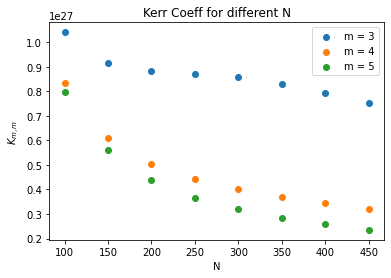

In [20]:
for m_index in range(0,len(m_range)):
        plt.scatter(N_axis,K_axis[m_index],label=f"m = {m_range[m_index]}")
plt.title("Kerr Coeff for different N")
plt.legend()
plt.xlabel("N")
plt.ylabel("$K_{m,m}$")

# Finding the Coupling coefficients $\kappa$

Define transmission matrix using eq 189 (and individual component matrices using eq 190-192)

Find reflection coefficient using eq 188

In [6]:
def S11(omega,phi_ext,n,Z_o,L_s,C_j= 1*(10**-12) , C_o= 1/2500*(10**-12) , L_j= 50*(10**-12)):
    
    # defining the individual array element transmission matrices
    
    L_j_dash=L_j/abs(np.cos(np.pi*phi_ext/phi_quantum))
    
    T_JJ = np.array([[1 ,((j*omega*L_j_dash)**-1 + j*omega*C_j)**-1 ],\
                     [ 0, 1 ]])
    T_L_s =np.array([[1 ,j*omega*L_s ],\
                     [ 0, 1 ]])
    T_term=np.array([[0,0],\
                     [0,1]])
    T_C_o=np.array([[1,0],\
                     [j*omega*C_o,1]])
    
    # multiply all(eq 189)
    T_temp = np.linalg.matrix_power(np.matmul(np.matmul(T_JJ,T_C_o),T_L_s),(n-1))
    
    
    T_net = np.matmul(np.matmul(T_temp,T_JJ),T_term)
    # Find S11 (eq 188)
    S_11 = (T_net[0,0] + T_net[0,1]/Z_o - T_net[1,0]* Z_o - T_net[1,1] )\
            /(T_net[0,0] + T_net[0,1]/Z_o + Z_o*T_net[1,0] + T_net[1,1])
    
    return S_11    

In [70]:
#

In [11]:
kappas(N=100,Z_o = 50,L_s=10*10**-12,C_o = C_o_range[C_o_index],modes_needed=10)

NameError: name 'C_o_range' is not defined

In [7]:
# the function that fits the for the kappa values (a hundred thanks to Nicolas sir for completing this part!)

def kappas(N,Z_o,L_s,Phi_ext=0,C_j= 1*(10**-12) , C_o= 1/2500*(10**-12) , L_j= 50*(10**-12),modes_needed=8,plot=False):
    resonance_freq=[]
    Qis=[]
    Qls=[]
    Qcs=[]
    
    freq_axis=np.linspace(0.1,20,500) #in GHz, needs to be multiplied by 10^9 before calling S11
    arg_S_11=np.zeros_like(freq_axis)
    mag_S_11=np.zeros_like(arg_S_11)
    for i in range(0,len(freq_axis)):
        arg_S_11[i] = np.angle(S11(2*np.pi*freq_axis[i]*(10**9),phi_ext=Phi_ext,n=N,Z_o=Z_o,L_s=L_s,L_j=L_j,C_j=C_j,C_o=C_o))
        mag_S_11[i] = np.abs(S11(2*np.pi*freq_axis[i]*(10**9),phi_ext=Phi_ext,n=N,Z_o=Z_o,L_s=L_s,L_j=L_j,C_j=C_j,C_o=C_o))
    modes=[] # stores the resonance values found numerically
    for i in range(0,len(arg_S_11)):
        if((arg_S_11[i]-arg_S_11[i-1]) > 2):  # if at this point there is a phase discontinuity, then this is a resonant freq 
            modes.append(i)
            
    kappas=np.zeros(shape=((min(modes_needed,len(modes)-1)),)) # stores kappas   
   

    # find sample points close to each mode
    for mode_number in range(0,len(kappas)-1):    
        mode_m_delta=abs((freq_axis[modes[mode_number]]-freq_axis[modes[mode_number+1]]))/2
        freq_axis_mode_m=np.linspace(freq_axis[modes[mode_number]]-mode_m_delta,freq_axis[modes[mode_number]]+mode_m_delta,500)
        #freq axis is in GHz,multiply by 10^9
        
        arg_S_11_mode_m=np.zeros_like(freq_axis_mode_m)
        mag_S_11_mode_m=np.zeros_like(arg_S_11_mode_m) 
        #for i in range(0,len(freq_axis_mode1)):
         #   arg_S_11_mode1[i] = np.angle(S11(2*np.pi*freq_axis_mode1[i]*(10**9),phi_ext=0,n=1000,Z_o=50,L_s=10*10**-1
        
        for i in range(0,len(freq_axis_mode_m)):
            arg_S_11_mode_m[i] = np.angle(S11(2*np.pi*freq_axis_mode_m[i]*(10**9),phi_ext=Phi_ext,n=N,Z_o=Z_o,L_s=L_s,L_j=L_j,C_j=C_j,C_o=C_o))        
            mag_S_11_mode_m[i] = np.abs(S11(2*np.pi*freq_axis_mode_m[i]*(10**9),phi_ext=Phi_ext,n=N,Z_o=Z_o,L_s=L_s,L_j=L_j,C_j=C_j,C_o=C_o))        
        
        z = mag_S_11_mode_m*np.exp(1j*arg_S_11_mode_m) # points in complex plane
        cf = circuit_test.reflection_port(freq_axis_mode_m, z)  
        cf.autofit()

        ampFitComp=np.abs(cf.z_data_sim) 
        phaseFit=np.angle(cf.z_data_sim)
        freqFit=cf.f_data 
        
        # store all resonance frquencies
        resonance_freq.append(cf.fitresults["fr"])
        #store all Qis, Qcs and Qls
        #Qis.append(cf.fitresults["Qi"])
        Qcs.append(cf.fitresults["Qc"])
        Qls.append(cf.fitresults["Ql"])
        
        
        # plots the fitting curves
        if (plot==True):
            fig = plt.figure()
            c = plt.plot(freq_axis_mode_m,arg_S_11_mode_m,linewidth=4, color='orange', label='RAW')
            plt.plot(freqFit,phaseFit,'k--',linewidth=3 ,label='FIT')
            plt.tick_params(axis='both', which='major', labelsize=18)
            plt.tick_params(axis='both', which='minor', labelsize=18)
            plt.ylabel('arg(S$_{11})$ ',fontsize=20)
            plt.xlabel('$\mathrm{f_{s}}$ (GHz)',fontsize=20)   
            plt.tick_params(length=6, width=2)
            leg=plt.legend(prop={'size': 11})
            fig.set_size_inches(5, 5)
            leg.get_frame().set_edgecolor('black')
            leg.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0)
            plt.show()
        
        
        
    resonance_freq=np.array(resonance_freq) # fitted resonance frequencies
    Qcs=np.array(Qcs) # fitted Qcs
    Qis=np.array(Qis)
    Qls=np.array(Qls)
    kappas=resonance_freq/Qls # kappa
    return kappas*10**3, resonance_freq,Qls,Qcs  # returns kappa in MHz
    
    
    
    

# Changing $C_o$ to change $\kappa$

In [18]:
Z_o =10 # so that the fitting is good

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:230: RuntimeWarning: invalid value encountered in sqrt
  fr_err, Ql_err, absQc_err, phi_err = np.sqrt(np.diag(cov))


0
1


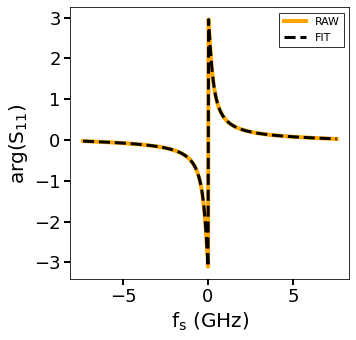

2


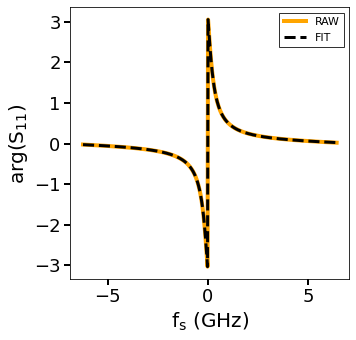

3


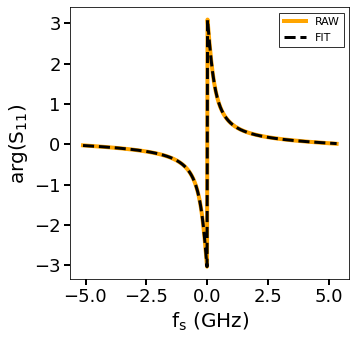

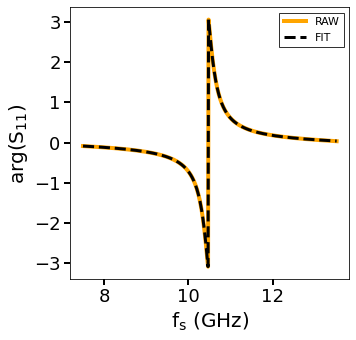

4


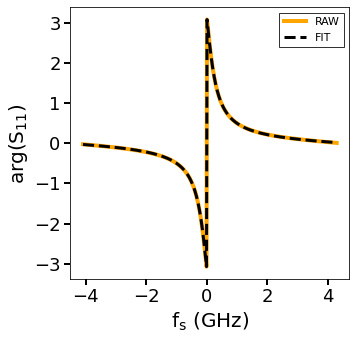

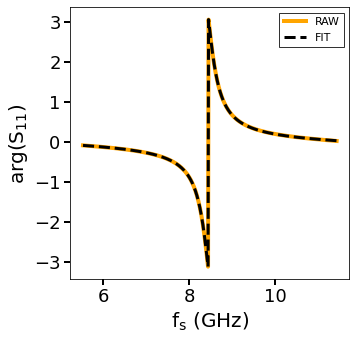

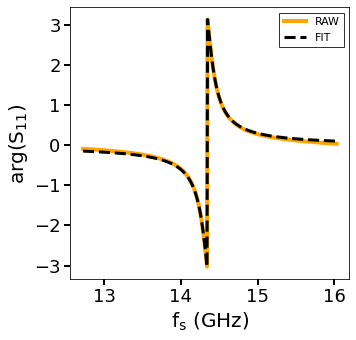

5


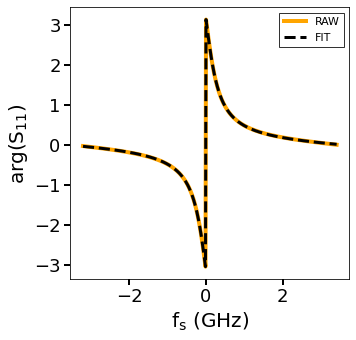

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.Qc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Juncti

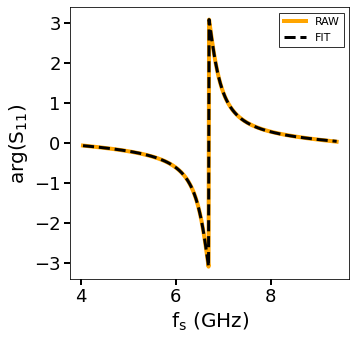

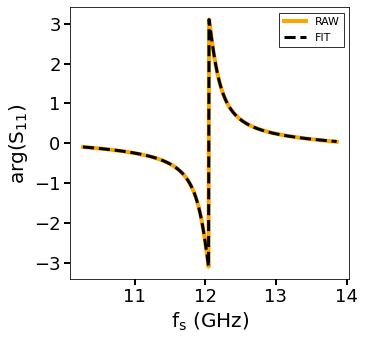

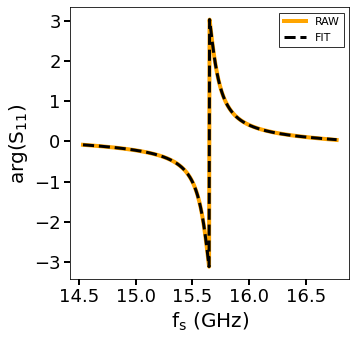

6


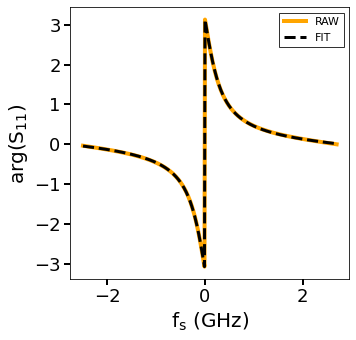

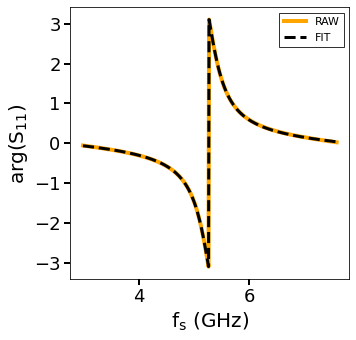

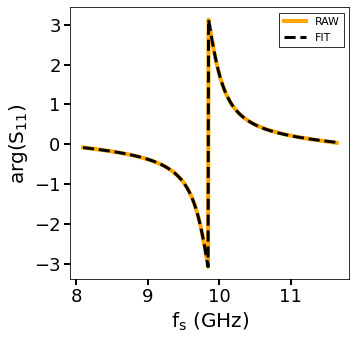

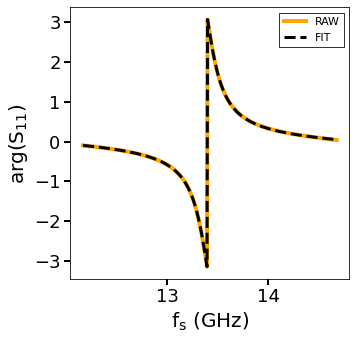

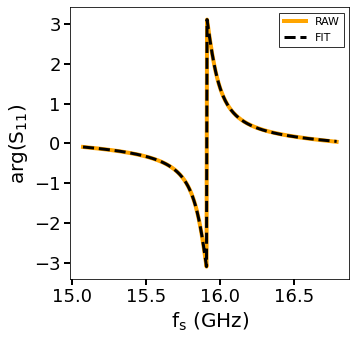

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

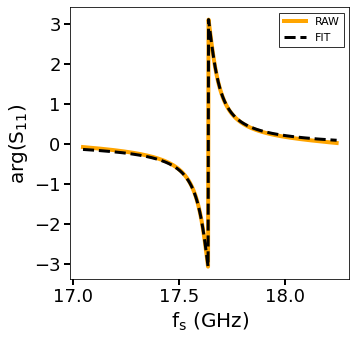

7


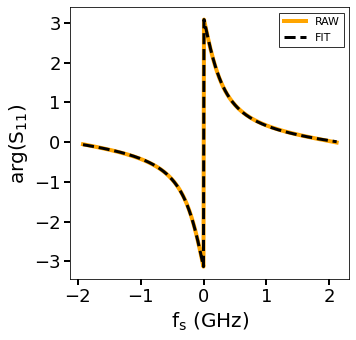

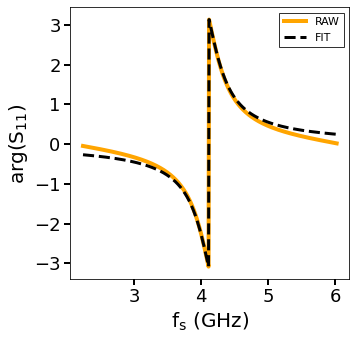

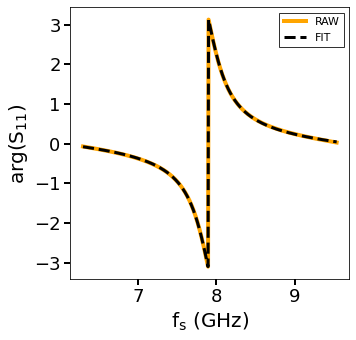

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.Qc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Juncti

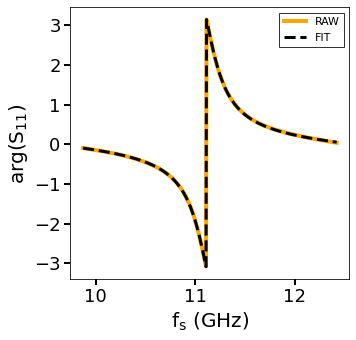

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

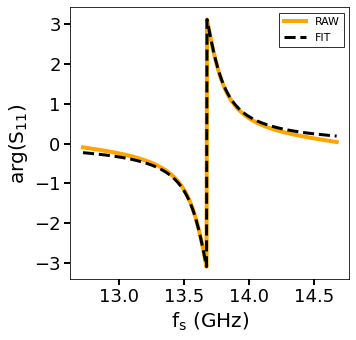

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

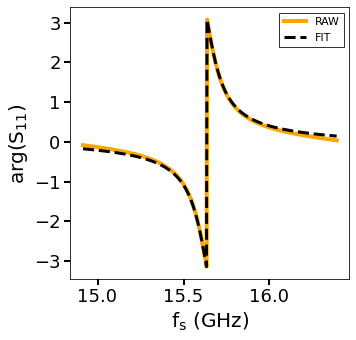

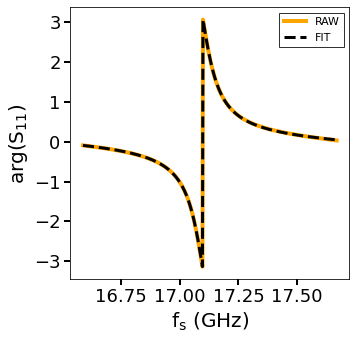

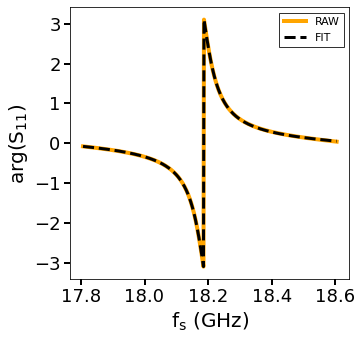

8


C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

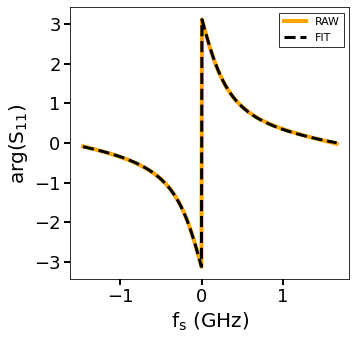

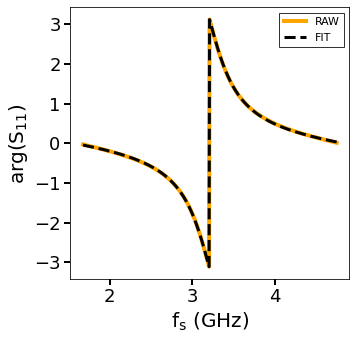

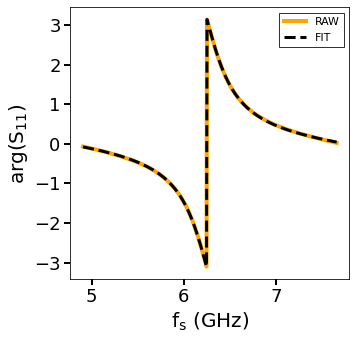

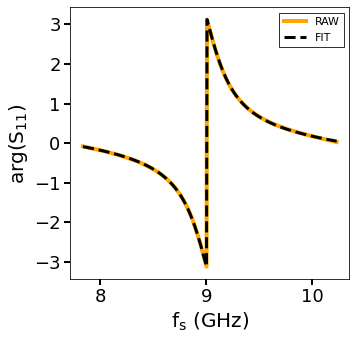

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.Qc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Juncti

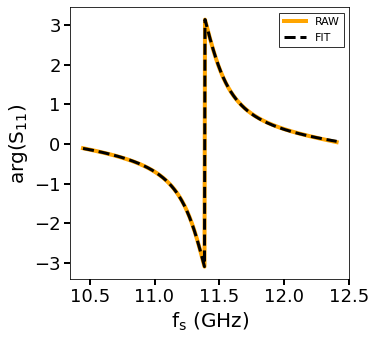

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

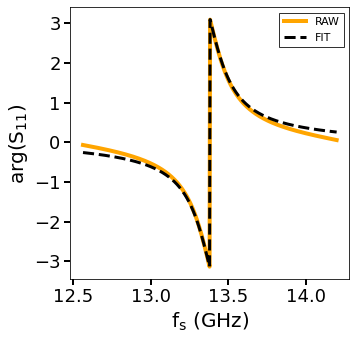

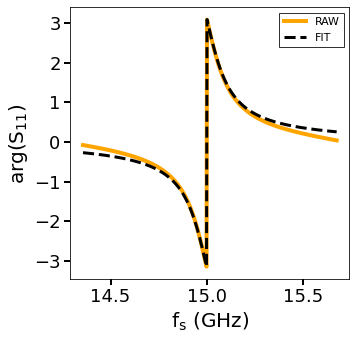

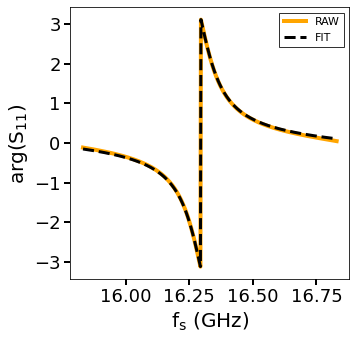

C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: Runti

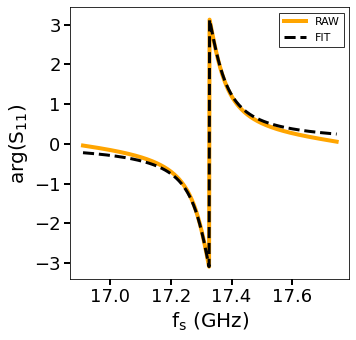

9


C:\Users\REET\AppData\Local\Temp/ipykernel_18928/3348212020.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kappa_values=np.array(kappa_values)


In [19]:
# Find Kappa for different modes.
# The fitting is bad after a range, hence Z_o =10 is used,to see the better trend in the curve
N =100
C_o_range=np.logspace(np.log10(1*C_o) ,np.log10(C_o*100),10)
kappa_values=[]

for C_o_index in range(0,len(C_o_range)):
    
    k,_,_,_ = kappas(N,Z_o =Z_o,L_s=10*10**-12,C_o = C_o_range[C_o_index],modes_needed=10,plot=True)
    kappa_values.append(k) 
    print(C_o_index)
kappa_values=np.array(kappa_values)    

In [22]:
# change font style

import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

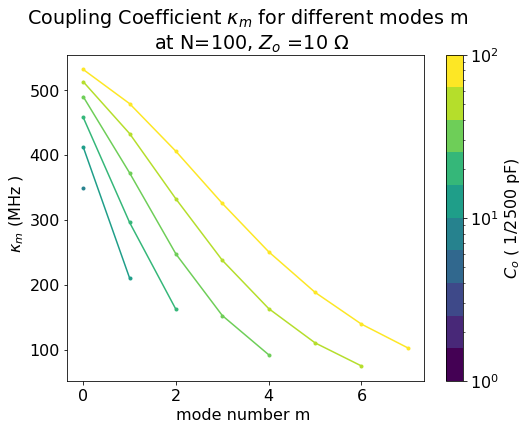

In [23]:
# colormap

#plot the coupling coefficients for different modes, with C_o on color bar
cmap = plt.get_cmap('viridis',len(C_o_range))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

for i in range(0,len(C_o_range)):
    ax1.plot(range(0,len(kappa_values[i][1:])),kappa_values[i][1:], 
                color=cmap(i),marker='.')

plt.title(f" Coupling Coefficient $\kappa_m$ for different modes m \n  at N={N}, $Z_o$ ={Z_o} $\Omega$")
plt.xlabel("mode number m ")
plt.ylabel("  $\kappa_{m}$ (MHz )")
# Normalizer
norm = mpl.colors.LogNorm(vmin=min(C_o_range/C_o), vmax=max(C_o_range/C_o))  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,label="$C_o$ ( 1/2500 pF)")
plt.show()

 # changing $N$ to change $\kappa$

In [24]:
C_o=1/2500 * 10**-12
N_range=np.arange(100,1001,10)
kappa_values=[]

for N_index in range(0,len(N_range)):
    
    k,_,_,_ = kappas(N_range[N_index],Z_o = 10,L_s=10*10**-12,C_o=C_o,modes_needed=10,plot=False)
    kappa_values.append(k) 
    print(k)
kappa_values=np.array(kappa_values) 

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[126.63246109]
[125.98739449]
[]
[]


[]
[]
[120.20120025]


[118.73682702]
[117.2202615]


[115.66410231]
[114.08360169]


[112.48736805]


[110.88403256  60.15676209]
[109.28131341]


[107.68553782]


[106.09975889  61.95725041]


C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:212: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi = 1. / (1./self.Ql - 1./self.Qc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  self.Qi_no_dia_corr = 1. / (1./self.Ql - 1./self.absQc)
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.absQc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  dabsQc = -1. / ((1./self.Ql - 1./self.absQc) * self.absQc)**2
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  dQl = 1. / ((1./self.Ql - 1./self.Qc) * self.Ql)**2
C:\Users\REET\Desktop\Dimer Josephson Juncti

[104.5289197   62.38693527]
[102.97764316]


[101.44720995  63.02580191]
[99.93975387 63.24570758]


[98.45670395 63.40408308]
[96.99938644]


[95.56864028 63.5591583 ]


[94.16665301 63.56489322]
[92.79076069 63.52563238]


C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:236: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]


[91.44426411 63.44833278]


[90.12574614 63.33484154]


[88.83510512 63.18705378]
[87.57184759 63.01039219]


[86.33629873 62.80642839]


[85.12741881 62.57771362]


[83.94567339 62.32665384]
[82.791314   62.05572119]


[81.66099554 61.76633474 40.71274761]
[80.55759088 61.46096481]


[79.47718089 61.14220287 41.20522933]


[78.42261875 60.80931119 41.41424934]


[77.39163744 60.46498052 41.59866152]


[76.38370625 60.11192153 41.76216212]


[75.39817192 59.74861018 41.90386942 27.24150217]


[74.43469766 59.37898037 42.02441411]


[73.49176794 59.00263196 42.1267891  27.8899679 ]


[72.57028943 58.61919682 42.21035308]
[71.66909106 58.23243766]


[70.78684888 57.84170423]


[69.9265699  57.44756317]


[69.0819373  57.04933297 42.37909661]


[68.25643313 56.65086296 42.38458404]


[67.44958987 56.25063031 42.37680076 29.69539634]


[66.66087659 55.84958678 42.35658095 29.89851891]


[65.88598273 55.44987414 42.32476205 30.23007666]


C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  dphi = -np.sin(self.phi) / (
C:\Users\REET\Desktop\Dimer Josephson Junction Arrays\circuit_test.py:249: RuntimeWarning: invalid value encountered in double_scalars
  dQl**2*cov[1][1]


[65.12922999 55.04835314 42.28164225 30.26713196]


[64.38930222 54.64725196 42.22810985 30.43334898]


[63.66180315 54.24717003 42.16480155]


[62.95116562 53.84782018 42.09234765 30.73253677]


[62.25507235 53.45147147 42.01259719]


[61.57416582 53.05505901 41.92333748 30.98842504]


[60.90589386 52.66221922 41.82657532 31.1002526  22.16320674]


[60.25101905 52.26979835 41.7225825 ]


[59.6091405  51.88129021 41.61349169 31.29620551]


[58.9799377  51.49352623 41.49668272]


[58.36303396 51.11005565 41.37558825]


[57.75799225 50.72760188 41.24767935 31.52158506 23.08406073]


[57.16487782 50.34977109 41.11465804 31.58078561]


[56.5849601  49.9742341  40.97850534 31.63089107 23.54501878]


[56.01412846 49.6006188  40.83667918 31.67468807 23.54869447 17.08378852]


[55.45405    49.23184505 40.69217285 31.70992545]
[54.90444428 48.86639883 40.54407047]


[54.36707219 48.50347    40.39091168 31.7610256  23.95239424]


[53.83763647 48.14454122 40.2362324  31.77747457]


[53.31866112 47.78829947 40.07711958 31.78780894]


[52.80823585 47.43612603 39.91691392 31.79074529]


[52.30910358 47.08675147 39.7543057  31.78942915 24.40023753]


[51.81686217 46.74140176 39.58951962 31.78271727 24.49634153]


[51.33549772 46.39890923 39.42109998 31.76950507]


C:\Users\REET\AppData\Local\Temp/ipykernel_18928/4188212638.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kappa_values=np.array(kappa_values)


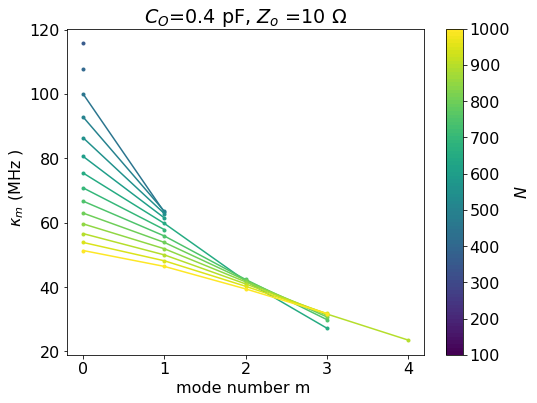

In [25]:
# plot kappa for different mode number, at a fixed C_o, with N on color bar
cmap = plt.get_cmap('viridis',len(N_range))
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
for i in range(0,len(N_range)):
    if(i%5==0):
        ax1.plot(range(0,len(kappa_values[i])),kappa_values[i], \
                color=cmap(i),marker='.')
plt.title(f"$C_O$={np.round(C_o*10**15,4)} pF, $Z_o$ ={10} $\Omega$")
plt.xlabel("mode number m ")
plt.ylabel("  $\kappa_{m}$ (MHz )")
# Normalizer
norm = mpl.colors.Normalize(vmin=min(N_range), vmax=max(N_range))  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,label="$N$")
plt.show()

# 3D plots

the code below uses the above basic codes to iterate over C_o and N simultaneously

In [ ]:
kappa_No_C_o=[]
N_range=range(100,1001,50)
for number_of_arrays in range(0,len(N_range)):
    C_o_range=np.linspace(C_o,C_o*600,100) # change limit to C_j
    kappa_values=[] 
    for C_o_index in range(0,len(C_o_range)):
        k,_,_,_ = kappas(N_range[number_of_arrays],Z_o =5,L_s=10*10**-12,C_o = C_o_range[C_o_index],modes_needed=10,plot=False)
        kappa_values.append(k) 
        
    kappa_No_C_o.append(np.array(kappa_values))
    
kappa_2d_array=np.array(kappa_No_C_o)        


In [ ]:
kappa_No_C_o

In [ ]:
temp=kappa_No_C_o
print(np.shape(temp))

In [24]:
mode_number=0
temp=np.zeros(shape=(len(N_range),len(C_o_range)))
for i in range(0,len(N_range)):
    for k in range(0,len(C_o_range)):
        temporary=kappa_No_C_o[i][k]
       
        try: temp[i][k]=temporary[mode_number]
        except: pass
 

In [73]:

np.shape(temp)

(10, 50)

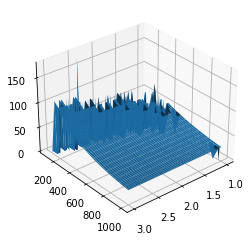

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




# Creates a 1D array of all possible x and y coordinates
x_coords =C_o_range
y_coords = N_range
# Creates 2D array with all possible combinations of x and y coordinates,
# so x_grid.shape = (100, 100) and y_grid.shape = (100, 100)
[x_grid, y_grid] = np.meshgrid(x_coords, y_coords)

# Evaluates z at all grid points
z_grid = temp

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid/C_o,y_grid,z_grid)

ax.view_init(30, 50)
plt.show()

The following generates an interactive plot

In [26]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
z = temp

fig = go.Figure(data=[go.Surface(z=z, x=np.array(x_coords)/C_o, y=np.array(y_coords))])
fig.update_layout(title="Change in kappa",xaxis_title="C_o",yaxis_title="N",
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [56]:
print(shape(kappa_No_C_o))

(3, 25)


In [ ]:
reshaped_kappa=np.zeros(shape=(len(kappa_values),len()))

In [64]:
temp_k = kappa_No_C_o[i,:][0]

In [66]:
print(temp_k)

[533.82776013 408.39271359 205.0271377 ]


In [ ]:
def k_N_c(kappa_No_C_o,mode):
    return kappa_No_C_o[:,:][mode]
    

In [ ]:
ax = plt.axes(projection='3d')


C_o_range=np.linspace(0.5*C_o ,C_o*3,25)
N_range
N,C=np.meshgrid(N,C_o_range)
for i in range(0,len(N_range)):
    print(i)
    #mode=range(0,len(kappa_values[i]))
    #print(kappa_values)
     # 0th mode
    ax.scatter3D(N_range,C_o_range,k_N_c(kappa_No_C_o,mode=0 ))


## Identifying the eigenmodes at which fitting is to be done

In [26]:
Z=50
N=1000
freq_axis=np.linspace(0.1,30,1000) #in GHz, needs to be multiplied by 10^9 before calling S11
arg_S_11=np.zeros_like(freq_axis)
for i in range(0,len(freq_axis)):
    arg_S_11[i] = np.angle(S11(2*np.pi*freq_axis[i]*(10**9),phi_ext=0,n=N,Z_o=Z,L_s=10*10**-12))

In [27]:
modes=[]
for i in range(0,len(arg_S_11)):
    if(arg_S_11[i]-arg_S_11[i-1] > 3): 
        modes.append(i)

Text(0, 0.5, '$arg(S_{11})$ in rad')

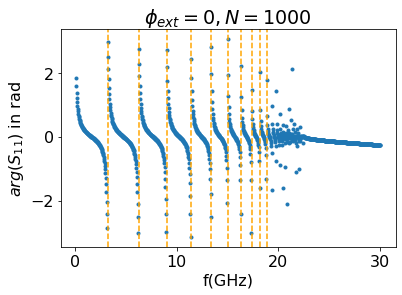

In [28]:
plt.scatter(freq_axis,arg_S_11,label=f"N = {1000}",marker='.')
plt.title("$\phi_{ext} = 0, N =1000$")
for l in modes:
    plt.axvline(freq_axis[l],linestyle='--',color='orange')
plt.xlabel("f(GHz)")
plt.ylabel("$arg(S_{11})$ in rad")

In [29]:
phi_ext_axis_color=np.linspace(-1,1,200)
freq_axis_color=np.linspace(0.1,15,200)
arg_S_11_color=np.zeros(shape=(len(freq_axis_color),len(phi_ext_axis_color)))
for i in range(0,len(freq_axis_color)):
    for l in range(len(phi_ext_axis_color)):
        arg_S_11_color[i,l] = np.angle(S11(omega=2*np.pi*freq_axis_color[i]*(10**9),phi_ext=phi_ext_axis_color[l]*phi_quantum,n=N,Z_o=Z,L_s=10*10**-12))

C:\Users\REET\miniconda3\lib\site-packages\numpy\linalg\linalg.py:664: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
C:\Users\REET\AppData\Local\Temp/ipykernel_18928/1697962085.py:20: RuntimeWarning: invalid value encountered in matmul
  T_net = np.matmul(np.matmul(T_temp,T_JJ),T_term)
C:\Users\REET\AppData\Local\Temp/ipykernel_18928/1697962085.py:22: RuntimeWarning: invalid value encountered in cdouble_scalars
  S_11 = (T_net[0,0] + T_net[0,1]/Z_o - T_net[1,0]* Z_o - T_net[1,1] )\


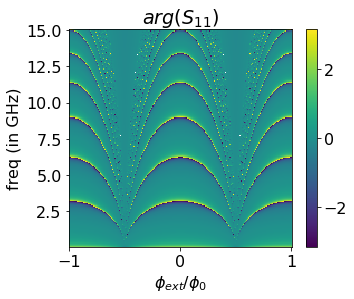

In [30]:
figure(figsize = (5,4 ))
px = plt.pcolormesh(phi_ext_axis_color,freq_axis_color,arg_S_11_color)
plt.colorbar(px)
plt.ylabel("freq (in GHz)")
plt.xlabel(r"$ \phi_{ext}/\phi_{0} $")
plt.title("$arg(S_{11})$")
plt.show()

# ROUGH